<a href="https://colab.research.google.com/github/manjeshsinghh/Anomaly-detection-in-network-traffic/blob/main/int432_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Timestamp', 'Source IP', 'Destination IP', 'Protocol',
       'Packet Size (Bytes)', 'Duration (ms)', 'Destination Port'],
      dtype='object')

Comparison of Unsupervised Evaluation Metrics:
+------------------------+------------------+--------+---------+
|         Metric         | Isolation Forest | DBSCAN | K-Means |
+------------------------+------------------+--------+---------+
|    Silhouette Score    |       0.14       |  0.07  |   0.19  |
|  Davies-Bouldin Index  |       7.40       |  2.54  |   4.14  |
|    K-Means Inertia     |       N/A        |  N/A   |  219.74 |
| Anomalies Detected (%) |      10.00       |  5.00  |   5.00  |
+------------------------+------------------+--------+---------+


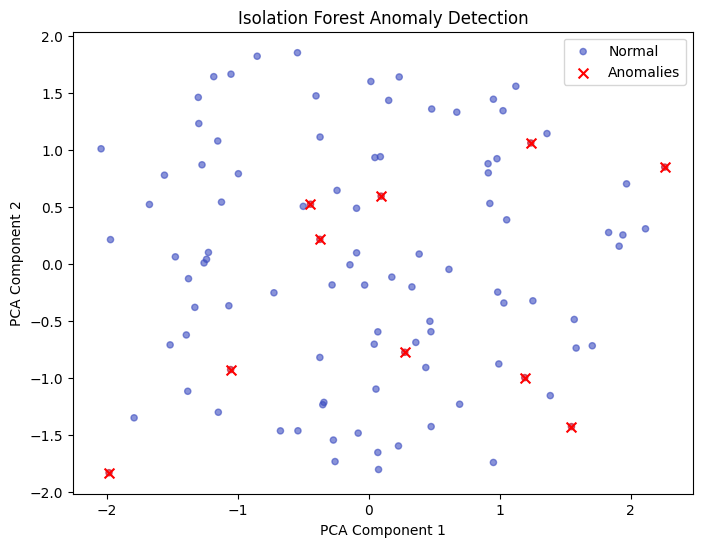

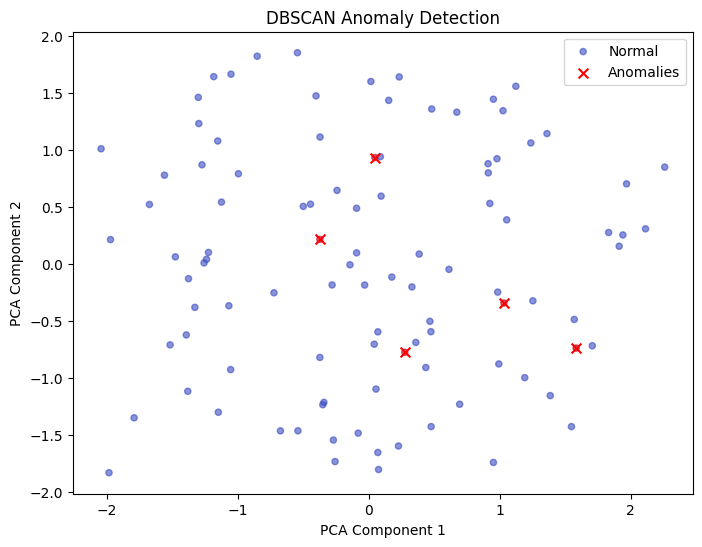

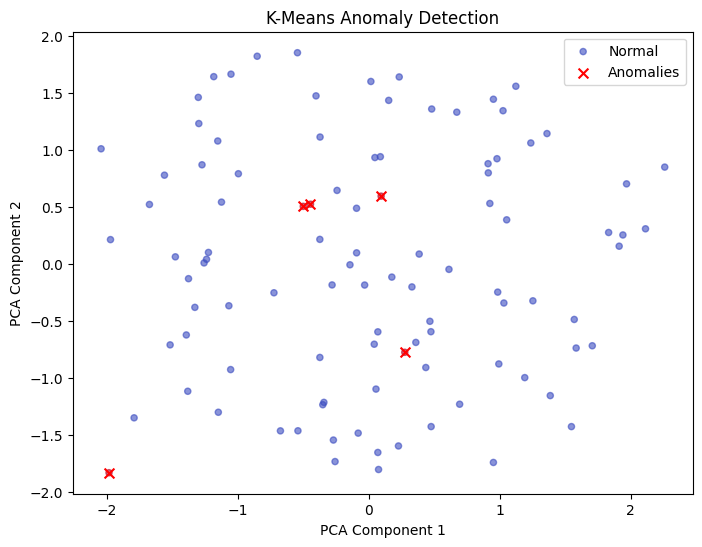


Anomalous Data Points (K-Means):
    Packet Size (Bytes)  Duration (ms)  Destination Port
28          1410.382098     720.519541             61949
31          1499.617606      76.603718              3473
34          1417.087032     747.130132             62921
48          1253.284102     854.952176             63095
63           186.814335     171.118872              2526


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from prettytable import PrettyTable

# Load your CSV data
# Replace 'your_file.csv' with the path to your CSV file
data = pd.read_csv('/content/network_traffic_unsupervised.csv')

# Display basic info about the dataset
print(data.columns)

data = pd.DataFrame({
    'Packet Size (Bytes)': np.random.rand(100) * 1500,
    'Duration (ms)': np.random.rand(100) * 1000,
    'Destination Port': np.random.randint(1, 65535, 100)
})

# Feature selection
features = ['Packet Size (Bytes)', 'Duration (ms)', 'Destination Port']
X = data[features].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 1. Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_preds = iso_forest.fit_predict(X_scaled)
iso_preds_binary = np.where(iso_preds == -1, 1, 0)  # Anomalies = 1, Normal = 0

# 2. DBSCAN
# Adjust eps and min_samples to find suitable values for your dataset
dbscan = DBSCAN(eps=0.8, min_samples=3)  # Adjusted hyperparameters
dbscan_preds = dbscan.fit_predict(X_scaled)
dbscan_preds_binary = np.where(dbscan_preds == -1, 1, 0)

# Check if DBSCAN found more than one cluster
n_clusters_dbscan = len(np.unique(dbscan_preds))
if n_clusters_dbscan <= 1:
    print("DBSCAN found only one cluster. Adjust eps and min_samples.")
    # Handle the case where DBSCAN finds only one cluster (e.g., skip silhouette calculation)

# 3. K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_preds = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_preds], axis=1)
threshold = np.percentile(distances, 95)  # Treat top 5% as anomalies
kmeans_preds_binary = (distances > threshold).astype(int)


# Unsupervised Evaluation Metrics
def calculate_unsupervised_metrics(X_scaled, iso_preds_binary, dbscan_preds_binary, kmeans_preds_binary):
    # Silhouette Score (higher is better)
    iso_silhouette = silhouette_score(X_scaled, iso_preds_binary)
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_preds_binary)
    kmeans_silhouette = silhouette_score(X_scaled, kmeans_preds_binary)

    # Davies-Bouldin Index (lower is better)
    iso_db_index = davies_bouldin_score(X_scaled, iso_preds_binary)
    dbscan_db_index = davies_bouldin_score(X_scaled, dbscan_preds_binary)
    kmeans_db_index = davies_bouldin_score(X_scaled, kmeans_preds_binary)

    # Inertia (for K-Means, lower is better)
    kmeans_inertia = kmeans.inertia_

    # Percentage of anomalies detected
    iso_anomalies = np.sum(iso_preds_binary) / len(iso_preds_binary) * 100
    dbscan_anomalies = np.sum(dbscan_preds_binary) / len(dbscan_preds_binary) * 100
    kmeans_anomalies = np.sum(kmeans_preds_binary) / len(kmeans_preds_binary) * 100

    # Create PrettyTable for comparison
    table = PrettyTable()
    table.field_names = ["Metric", "Isolation Forest", "DBSCAN", "K-Means"]

    # Add rows to the table
    table.add_row(["Silhouette Score", f"{iso_silhouette:.2f}", f"{dbscan_silhouette:.2f}", f"{kmeans_silhouette:.2f}"])
    table.add_row(["Davies-Bouldin Index", f"{iso_db_index:.2f}", f"{dbscan_db_index:.2f}", f"{kmeans_db_index:.2f}"])
    table.add_row(["K-Means Inertia", "N/A", "N/A", f"{kmeans_inertia:.2f}"])
    table.add_row(["Anomalies Detected (%)", f"{iso_anomalies:.2f}", f"{dbscan_anomalies:.2f}", f"{kmeans_anomalies:.2f}"])

    # Print the table
    print("\nComparison of Unsupervised Evaluation Metrics:")
    print(table)

# Call the evaluation function
calculate_unsupervised_metrics(X_scaled, iso_preds_binary, dbscan_preds_binary, kmeans_preds_binary)

# Visualization function to plot anomalies
def plot_anomalies(X, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm', s=20, alpha=0.6, label="Normal")
    plt.scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1], color='red', s=50, label="Anomalies", marker='x')
    plt.title(f"{model_name} Anomaly Detection")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

# Plot results for Isolation Forest
plot_anomalies(X_pca, iso_preds_binary, "Isolation Forest")

# Plot results for DBSCAN
plot_anomalies(X_pca, dbscan_preds_binary, "DBSCAN")

# Plot results for K-Means
plot_anomalies(X_pca, kmeans_preds_binary, "K-Means")

anomalous_data = data[kmeans_preds_binary == 1]
print("\nAnomalous Data Points (K-Means):")
print(anomalous_data)